In [4]:
import pandas as pd
import numpy 
import os
import git
import pickle
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot
import numpy as np
import re
from collections import Counter
# import gensim
# from gensim import corpora
import os
import networkx as nx
import ast

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.utils import shuffle

In [6]:
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import SGD
from keras.models import Model, Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Reshape
from keras.layers import Average
from keras.layers import Dropout
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

In [8]:
## Read the labelled files and the poly_user
def get_git_root(path):
	git_repo = git.Repo(path, search_parent_directories=True)
	git_root = git_repo.git.rev_parse("--show-toplevel")
	return git_root

In [9]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [10]:
# setup env
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/xavlock2345/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xavlock2345/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
## tokenize the text..
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
# from keras.preprocessing.text import Tokenizer as keras_Tokenizer
from sklearn.metrics import classification_report
# from keras.layers import Embedding
from nltk.tokenize import TweetTokenizer
tweet_tknzr = TweetTokenizer()
def get_tokens(sentence):
#     tokens = nltk.word_tokenize(sentence)  # now using tweet tokenizer
    tokens = tweet_tknzr.tokenize(sentence)
    tokens = [token for token in tokens if (token not in stopwords and len(token) > 1)]
    tokens = [get_lemma(token) for token in tokens]
    return (tokens)

In [12]:
import re
def clean_text(text):
    text = re.sub(r'(https?://\S+)', "", text) ## remove url
    text = re.sub(r'(\@\w+)', "author",text)   ## remove @ mentions with author
    text = re.sub(r'(@)', "",text)             ## remove @ symbols
    text = re.sub(r'(author)',"",text)         ## remove author
    text = re.sub(r'(#)', "",text)             ## removing the hashtags signal 
    text = re.sub(r'(RT )', "",text)         ## remove the retweet info as they dont convey any information
    text.rstrip 
    text.lstrip
    return(text)

In [13]:
# create the word2vec dict from the dictionary
def get_word2vec(file_path):
    file = open(file_path, "r")
    if (file):
        word2vec = dict()
#         split = file.read().splitlines()
        for line in file:
            split_line = line.split(' ')
            key = split_line[0] # the first word is the key
            value = np.array([float(val) for val in split_line[1:]])
            word2vec[key] = value
        return (word2vec)
    else:
        print("invalid fiel path")

In [14]:
## calculate the mean of the embeddings
class MeanEmbeddingVectorizer(object):
	def __init__(self, word2vec):
		self.word2vec = word2vec
		# if a text is empty we should return a vector of zeros
		# with the same dimensionality as all the other vectors
		self.dim = len(next(iter(word2vec.values())))

	def fit(self, X, y):
		return self

	def transform(self, X):
		return np.array([
			np.mean([self.word2vec[w] for w in words if w in self.word2vec]
					or [np.zeros(self.dim)], axis=0)
			for words in tqdm(X)
		])

In [15]:
## get the embedding matrix weights:
from numpy import zeros
def get_embedding_matrix(keras_tkzr,word2vec):
    vocab_size = len(keras_tkzr.word_index) + 1
    embedding_matrix = zeros((vocab_size, 100))
    for word, i in keras_tkzr.word_index.items():
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return (embedding_matrix,vocab_size)

In [16]:
## pass to the bi-lstm model
def create_model(max_len,vocab_size,embedding_matrix):
    input = Input(shape=(max_len,))
    model = Embedding(vocab_size,100,weights=[embedding_matrix],input_length=max_len)(input)
    model =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.50),merge_mode='concat')(model)
    model = TimeDistributed(Dense(100,activation='relu'))(model)
    model = Flatten()(model)
    model = Dense(100,activation='relu')(model)
    output = Dense(3,activation='softmax')(model)
    model = Model(input,output)
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return model

In [17]:
def load_data(df,max_len):
    keras_tkzr = keras_Tokenizer()
    le = LabelEncoder()
    print("fitting tokenizer on text")
    keras_tkzr.fit_on_texts(df["tweetText"])
    ## getting input X
    print("getting the encoded data")
    encoded_docs = keras_tkzr.texts_to_sequences(df["tweetText"])
    print("padding the input sequnce")
    X = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
    ## getting output Y
    print("labelling data")
    Y = (list(df['label']))
    le.fit(Y)
    le.classes_
    y = le.transform(Y)
    return (X,y,keras_tkzr)

In [18]:
## get the trained model
def train_evaluate_model(model,X_train,Y_train,X_test,Y_test):
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
    print('Accuracy: %f' % (accuracy*100))
    Y_pred = model.predict(X_test)
    y_pred = np.array([np.argmax(pred) for pred in Y_pred])
    # scores = cross_val_score(model, X_test, Y_test, cv=5)
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    precision,recall,fscore,_ = precision_recall_fscore_support(Y_test,y_pred)
    return (model,precision,recall,fscore)

In [19]:
def fit_model(model,X_train,Y_train,epoch):
    hist = model.fit(X_train,Y_train,validation_split=0.25, nb_epoch = epoch, verbose = 2)
    return model,hist

In [20]:
def get_tokens_split(s):
    a = list(s.split())
    return(a)

In [21]:
import pickle
def dump_obj(obj,pathname):
    with open(pathname,"wb") as f:
        pickle.dump(obj,f)

In [22]:
top_dir = os.path.join(get_git_root(os.getcwd()))
input_dir = os.path.join(get_git_root(os.getcwd()),"input")
embeddings_dir  = os.path.join(get_git_root(os.getcwd()),"input","embeddings")
annotatted_dir = os.path.join(input_dir,"annotated_data")
classifier_dir = os.path.join(get_git_root(os.getcwd()),"models","classifier")
model_dir = os.path.join(get_git_root(os.getcwd()),"models")
poly_dir = os.path.join(model_dir,"poly_users")

In [19]:
glove_embeddings = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")

In [20]:
# weed data , poly data
weed_data = pd.read_csv(os.path.join(input_dir,"weed_data_text2.csv"),lineterminator="\n")
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")
# first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")

In [24]:
# labelled_data = pd.read_csv(os.path.join(input_dir,"label_data","label_data.csv"),lineterminator="\n")

In [22]:
# df_following_final = pd.read_csv(os.path.join(input_dir,"following_final.csv"))

In [23]:
df_dataset = pd.read_csv(os.path.join(input_dir,"dataset.csv"),lineterminator="\n")

In [24]:
df_annotation = pd.read_excel(os.path.join(annotatted_dir,"annotated_new.xlsx"))

In [ ]:
print(len(df_dataset))   # 11,578,887
print(len(df_dataset.userID.unique())) # 551,261

In [44]:
df_dataset.head(5)

,userID,tweetId,tweetCreatedAt,tweetText
0,768566977384312832,800352533508136961,2016-11-20 14:58:08,I just wanna chill smoke weed watch movies and possibly bowl today.
1,722831808593731584,838220580591546368,2017-03-05 02:52:14,Marijuana was initially made illegal in 1937 by a man who testified the drug made white women want to be with black men.
2,2270846172,849375958910074880,2017-04-04 21:39:43,"i want to go a simpler time, a time where mcdonald's had a mascot that was an anthropomorphic nug of weed https://t.co/Gj305Abss3"
3,2942106408,1034814696560324609,2018-08-29 14:47:04,weed smells so fucking beautiful that shit really turns me on
4,529061796,520808303262433282,2014-10-11 05:29:10,The day josh tried really hard not to smoke weed


## predicting promoter, regular, news from data using bilstm model -- finally use svm

### loading the svm vectorizer trained on annottaion data

In [27]:
# len(df_annotation)
## 0 -news
## 1 - promo
## 2 -regular users
# print(df_annotation.label.value_counts())
# df_annotation = df_annotation.sample(frac=1)
# df_annotation = df_annotation.reset_index(drop=True)
# ## take a balnced sample of 200 from each category
# df_news = (df_annotation[df_annotation.label == 0])[:200] 
# df_reg = (df_annotation[df_annotation.label == 2])[:200] 
# df_promo = (df_annotation[df_annotation.label == 1])[:200] 
# df_annotation = pd.concat([df_news,df_promo,df_reg])
# ## random sample annotation file
# df_annotation = df_annotation.sample(frac=1).reset_index(drop=True)

# ## tokenize the sentences
# df_annotation['tweetText'] = df_annotation['tweetText'].apply(clean_text)
# df_annotation.loc[df_annotation.label.isin([1,2])].head(200)

## looking at the tokenized data
# df_test = pd.DataFrame()
# df_test["tweetText"] = list(df_annotation['tweetText'].apply(get_tokens))
# df_test['label'] = list(df_annotation["label"])

# getting mean , quantile length of text
# df_len = list()
# for tokens in token_list:
#     df_len.append(len(tokens))
# df_len = pd.DataFrame(df_len)
# df_len.boxplot()
# df_len.describe()
# max_len = int(df_len.quantile(0.95))  ## take the max_len = 90 percentile
# max_len = 27


# df_annotation["tweetText"] = df_annotation["tweetText"].apply(prepare_text_LDA)
# data = df_annotation["tweetText"]
# y = list(df_annotation["label"])


# import sklearn
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split
# train_data, test_data, Y_train, Y_test = train_test_split(data, y, test_size=0.20, random_state=4,shuffle=True)

# tf_idf = TfidfVectorizer(sublinear_tf=True)
# tf_idf.fit(train_data)  ## fit on train data

# from sklearn.decomposition import TruncatedSVD
# from sklearn.metrics import classification_report

# ## transform train and test data
# X_test = tf_idf.transform(test_data)
# X_train = tf_idf.transform(train_data)

# svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
# svd.fit(X_train)

# # X_train = svd.transform(X_train)
# # X_test = svd.transform(X_test)

# svm = LinearSVC(C=1, verbose=1)
# svm.fit(X_train,Y_train)
# y_pred = svm.predict(X_test)

# data = df_dataset["tweetText"]
# X = tf_idf.transform(data)
# y = svm.predict(X) 

In [ ]:
## load the model and tokenizer
# svm_tf = pickle.load(open(os.path.join(classifier_dir,"annotation_classifier","svm_tf.pkl"),"rb"))
# tfidf_vect = pickle.load(open(os.path.join(classifier_dir,"annotation_classifier","tf_idf_vect.pkl"),"rb"))

In [56]:
data = df_dataset["tweetText"]
X = tfidf_vect.transform(data)

In [60]:
df_dataset["label"] = y

In [59]:
print(X.shape)
print(y.shape)

(12088584, 2840)
(12088584,)


In [61]:
## regualr tweets
use= len(df_dataset.loc[df_dataset.label == 2])
print(use/len(df_dataset))
print(use)

0.5237348725045051
6331213


In [62]:
## news tweets
news = len(df_dataset.loc[df_dataset.label == 0])
print(news/ len(df_dataset))

0.22325741377153852


In [63]:
## promotional tweets
prom = len(df_dataset.loc[df_dataset.label == 1])
print(prom/ len(df_dataset))

0.2530077137239564


## predicting regular, promoters and news users

In [65]:
temp = pd.get_dummies(df_dataset,columns=["label"],prefix=['cat'])
users_type = temp.groupby(by="userID").agg({'cat_0': 'sum','cat_1':'sum','cat_2':'sum'})
users_type = users_type.reset_index()
users_type["label"] = users_type[['cat_0','cat_1','cat_2']].idxmax(axis=1)
## sanity check
# regular tweets 5675561
(np.sum(list(users_type["cat_2"])))

6331213.0

### plot of user, promoter and news..

total users 887180
regular_users 673724
promoters users 91130
news users, 122326
887180
887180


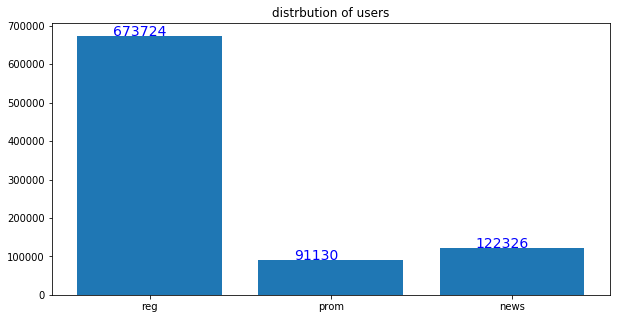

In [36]:
## no of users in each category
print("total users",len(users_type))
print("regular_users",len(users_type.loc[users_type.label == "cat_2"]))
print("promoters users",len(users_type.loc[users_type.label == "cat_1"]))
print("news users,",len(users_type.loc[users_type.label == "cat_0"]))
users_ = {"reg":len(users_type.loc[users_type.label == "cat_2"]),
 "prom":len(users_type.loc[users_type.label == "cat_1"]),
 "news":len(users_type.loc[users_type.label == "cat_0"])}

## sanity check
print(np.sum(list(users_.values())))
print(len(users_type.userID.unique()))

## plotting each user by category
fig, ax = plt.subplots(figsize=(10,5)) 
ax.set_title("distrbution of users")
ax.bar(users_.keys(),users_.values())
for idx,(key,value) in enumerate(users_.items()):
    ax.text( idx - 0.2 ,value + 0.5, value, color='blue',fontsize=14)

### plotting stack plot for each user with 3 category of tweet

In [78]:
import pandas as pd
import os
labelled_data = pd.read_csv(os.path.join(input_dir,"label_data","label_data.csv"),lineterminator="\n")

In [100]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
enc = OneHotEncoder()
le = LabelEncoder()

In [148]:
viz_data = labelled_data[["userID","label"]]

In [149]:
viz_data.to_csv("labelled_data.csv")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/io/formats/format.py", line 1652, in save
    self._save()
  File "/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/io/formats/format.py", line 1754, in _save
    self._save_chunk(start_i, end_i)
  File "/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/io/formats/format.py", line 1780, in _save_chunk
    lib.write_csv_rows(self.data, ix, self.nlevels, self.cols, self.writer)
  File "pandas/_libs/lib.pyx", line 1035, in pandas._libs.lib.write_csv_rows
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-149-534248239464>", line 1, i

TypeError: must be str, not list

In [ ]:
labels = labelled_data["label"]

In [ ]:
enc.fit(labels.reshape(-1,1))

In [ ]:
enc.active_features_

In [ ]:
categories = enc.transform(labels.reshape(-1,1))
categories = categories.toarray()

In [150]:
df_categories = pd.DataFrame(categories,columns=["news","promoter","regular"])
df_categories["userID"] = viz_data["userID"]
df_categories = df_categories.groupby("userID").agg({"news":"sum","promoter":"sum","regular":"sum"})
df_categories["label"]= df_categories[['news','promoter','regular']].idxmax(axis=1)

In [151]:
le.fit(df_categories["label"])
df_categories["label"] = le.transform(df_categories["label"])
df_categories = df_categories.reset_index()
## dumping the file
# df_categories.to_csv(os.path.join(input_dir,"user_label.csv"),index=None)

In [152]:
df_categories["sum"] = df_categories[["news","promoter","regular"]].sum(axis=1) 

In [153]:
df_categories["news"] = df_categories["news"] / df_categories["sum"]
df_categories["promoter"] = df_categories["promoter"] /df_categories["sum"]
df_categories["regular"] = df_categories["regular"] / df_categories["sum"]

In [154]:
## sanity check
len(df_categories.loc[df_categories.label == 2])

673724

In [211]:
df_categories_sub  = df_categories[:4000] ## taking a subset of users

In [212]:
df_categories_sub = df_categories_sub.sort_values(by=["regular","promoter","news"],ascending=False)

In [213]:
# users = [str(user) for user in np.arange(len(df_categories_sub))]
uexp = list(df_categories_sub["regular"])
news = list(df_categories_sub["promoter"])
prom = list(df_categories_sub["news"])

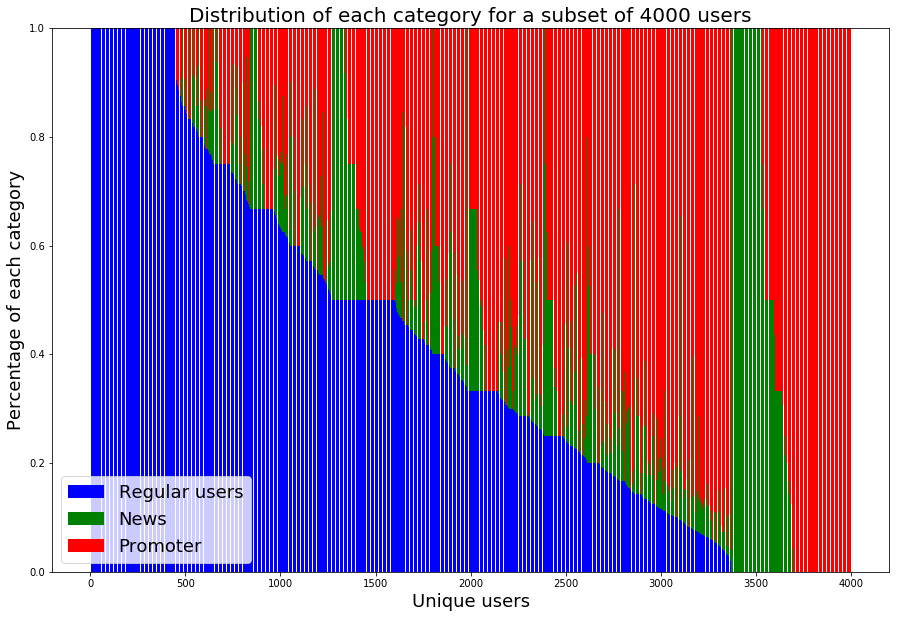

In [215]:
plt.figure(figsize=(15,10))
users = np.arange(len(uexp))
p1 = plt.bar(users, uexp, color='b',label= "Regular users")
p2 = plt.bar(users, news, bottom=np.array(uexp), color='g',label="News")
p3 = plt.bar(users, prom, 
             bottom=np.array(uexp)+np.array(news), color='r', label= "Promoter")
# p4 = plt.bar(ind, dataset[4], width,
#              bottom=np.array(dataset[1])+np.array(dataset[2])+np.array(dataset[3]),
#              color='c')
plt.xlabel("Unique users",fontsize=18)
plt.ylabel("Percentage of each category",fontsize=18)
plt.title("Distribution of each category for a subset of 4000 users",fontsize=20)
plt.legend(fontsize=18)
plt.show()

### getting the normal users

In [37]:
## getting all the tweets from normal users(who have max number of user expressed tweets)
regular_users = list(users_type["userID"].loc[users_type.label == "cat_2"])
normal_tweets = (df_dataset.loc[df_dataset.userID.isin(regular_users)])

In [39]:
## dump labelled and user types
users_type.to_csv(os.path.join(input_dir,"labelled_data","users_type.csv"))
df_dataset.to_csv(os.path.join(input_dir,"labelled_data","dataset.csv"))

In [56]:
len(regular_users)

673724

In [42]:
len(normal_tweets)

6886772

## predicting poly and mono users.. (check with most common words as well)

In [24]:
def build_vocab(tokens_list):
    vocab = Counter()
    for tokens in tokens_list:
        vocab.update(tokens)
    return vocab

In [38]:
# return clean text
def prepare_text_LDA(sentence):
#     tokens = nltk.word_tokenize(sentence)  # now using tweet tokenizer
#     tweet_tknzr = TweetTokenizer()
#     tokens = tweet_tknzr.tokenize(sentence)
    tokens = get_tokens_split(sentence)
    tokens = [token.lower() for token in tokens if (token.lower() not in stopwords and len(token) > 1)] # stopwords removal
#     tokens = [get_lemma(token) for token in tokens]  # lemmatization
    return (" ".join(tokens))

In [25]:
## join al the of the tweets for each user
def get_tweets_user(df):
    tqdm.pandas()
    df = df.groupby(['userID'])['tweetText'].progress_apply(lambda x: ','.join(x)).reset_index()
    return (df)

In [27]:
len(weed_data.userID.unique())

NameError: name 'weed_data' is not defined

In [ ]:
## loading the labelled regular users
regular_users = pickle.load(open(os.path.join(poly_dir,"regular_users.pkl"),"rb"))
# weed data , poly data
weed_data = pd.read_csv(os.path.join(input_dir,"weed_data_text2.csv"),lineterminator="\n")
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")

In [ ]:
## poly are users in weed data and mono are remaining users
poly_data = weed_data.loc[weed_data.userID.isin(regular_users)]
mono_data = juul_data.loc[juul_data.userID.isin(regular_users)]

In [29]:
## poly_users are the ones defined in weed data and rest are considered as mono
poly_users = (poly_data.userID.unique())
print("poly data users",len(poly_users))
print("juul data total users",len(mono_data.userID.unique()))
# total_users = list(poly_users) + list(mono_data.userID.unique())

poly data users 432316
juul data total users 673724


In [30]:
mono_users = list(set(mono_data.userID.unique()) - set(poly_users))
print("total users = ", len(regular_users))
print("no of poly users = ", len(poly_users))
print("no of mono users = ", len(mono_users))
print("% of poly users is ", len(poly_users) / len(regular_users))
print("% of mono users is ", len(mono_users) / len(regular_users))

total users =  673724
no of poly users =  432316
no of mono users =  241408
% of poly users is  0.6416811632062981
% of mono users is  0.35831883679370186


## dump the users

In [308]:
# dump the poly_users,regualar_users
poly_dir = os.path.join(model_dir,"poly_users")

pathname = os.path.join(poly_dir,"poly_users.pkl")
dump_obj(poly_users,pathname)
pathname = os.path.join(poly_dir,"regular_users.pkl")
dump_obj(regular_users,pathname)
pathname = os.path.join(poly_dir, "mono_users.pkl")
dump_obj(mono_users,pathname)

### load the poly - mono users

In [22]:
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
regular_users = pickle.load(open(os.path.join(poly_dir,"regular_users.pkl"),"rb"))
# df_dataset = pd.read_csv(os.path.join(input_dir,"labelled_data","tweets_predicted.csv"),lineterminator="\n")

In [23]:
# normal_tweets = df_dataset.loc[df_dataset.userID.isin(normal_users)]
poly_tweets = df_dataset.loc[df_dataset.userID.isin(poly_users)]
print("poly_users",len(poly_users))
print("poly_tweets",len(poly_tweets))

mono_users = list(set(regular_users) - set(poly_users))
mono_tweets = df_dataset.loc[df_dataset.userID.isin(mono_users)]
print("mono users",len(mono_users))
print("mono tweets", len(mono_tweets))

poly_users 432316
poly_tweets 6512011
mono users 241408
mono tweets 374761


### with rt

In [27]:
print("all tweets by poly users: ", len(poly_tweets))
print("poly users (based with retweets):", len(poly_tweets.userID.unique()))

all tweets by poly users:  6512011
poly users (based with retweets): 432316


In [28]:
print("all tweets by mono users: ", len(mono_tweets))
print("mono users (based with retweets):", len(mono_tweets.userID.unique()))

all tweets by mono users:  374761
mono users (based with retweets): 241408


In [ ]:
## cleaning the text
tqdm.pandas()
poly_tweets["tweetText"] = poly_tweets["tweetText"].apply(clean_text)
mono_tweets["tweetText"] = mono_tweets["tweetText"].apply(clean_text)
# ## tokenizing and lemmatizing
poly_tweets["tweetText"] = (poly_tweets["tweetText"].apply(prepare_text_LDA))
mono_tweets["tweetText"] = mono_tweets["tweetText"].apply(prepare_text_LDA)

## get the most common words

### getting most coomon words for each user

In [39]:
poly_tweets["tweetText"] = poly_tweets["tweetText"].progress_apply(clean_text)
mono_tweets["tweetText"] = mono_tweets["tweetText"].progress_apply(clean_text)

In [ ]:
tqdm.pandas()
poly_tweets_user = get_tweets_user(poly_tweets)

In [ ]:
mono_tweets_user = get_tweets_user(mono_tweets)

In [ ]:
poly_tweets_user["tweetText"] = poly_tweets_user["tweetText"].progress_apply(prepare_text_LDA)
mono_tweets_user["tweetText"] = mono_tweets_user["tweetText"].progress_apply(prepare_text_LDA√)

In [ ]:
poly_tweets_user

In [ ]:
tokens_p = list(poly_tweets_user["tweetText"].progress_apply(get_tokens_split))
tokens_j = list(mono_tweets_user["tweetText"].progress_apply(get_tokens_split))

In [ ]:
vocab = build_vocab(tokens_p)

In [ ]:
np.array([ele[0] for ele in list(vocab.most_common()[:30])])

In [ ]:
## most common words for juul user tweets
vocab1 = build_vocab(tokens_j)

In [ ]:
np.array([ele[0] for ele in list(vocab1.most_common()[:30])])

## LDA

In [ ]:
temp_dir = os.path.join(model_dir,"temp")

In [ ]:
dictionary = corpora.Dictionary(tokens_p)  # tokens_j
corpus = [dictionary.doc2bow(text) for text in tokens_p] # tokens_j
pickle.dump(corpus, open(os.path.join(temp_dir,'corpus_m.pkl'), 'wb'))
dictionary.save(os.path.join(temp_dir,'dictionary_m.gensim'))
## LDA
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=8)
ldamodel.save(os.path.join(temp_dir,'model_m.gensim'))
topics = ldamodel.print_topics(num_words=4)

In [ ]:
for topic in topics:
    print(topic)

In [ ]:
## poly
dictionary = gensim.corpora.Dictionary.load(os.path.join(temp_dir,'dictionary_m.gensim'))
corpus = pickle.load(open(os.path.join(temp_dir,'corpus_m.pkl'), 'rb'))
lda = gensim.models.ldamodel.LdaModel.load(os.path.join(temp_dir,'model_m.gensim'))
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
##### mono
dictionary = corpora.Dictionary(tokens_j)  # tokens_j
corpus = [dictionary.doc2bow(text) for text in tokens_j] # tokens_j
pickle.dump(corpus, open(os.path.join(temp_dir,'corpus_m.pkl'), 'wb'))
dictionary.save(os.path.join(temp_dir,'dictionary_m.gensim'))
## LDA
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=8)
ldamodel.save(os.path.join(temp_dir,'model_m.gensim'))
topics = ldamodel.print_topics(num_words=4)

In [ ]:
## mono
dictionary = gensim.corpora.Dictionary.load(os.path.join(temp_dir,'dictionary_m.gensim'))
corpus = pickle.load(open(os.path.join(temp_dir,'corpus_m.pkl'), 'rb'))
lda = gensim.models.ldamodel.LdaModel.load(os.path.join(temp_dir,'model_m.gensim'))
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## get further categorization of poly_subtypes

### getting first occurances of each user  - consolidation file

### for poly catgories {j_before and j_after} based on juul_data and weed 

In [303]:
first = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
first = first.loc[first.userID.isin(poly_users)]  ## we only look for poly users and dicard the rest

first["juul_first"] = pd.to_datetime(first["juul_first"])
first["weed_first"] = pd.to_datetime(first["weed_first"])
first['category'] = first.apply(lambda x : 'j_before' if x['juul_first'] <= x['weed_first'] else "j_after", axis=1)


In [100]:
print("Poly type users calculated")
print("total poly users =", len(poly_users))
print("****************\n")
juul_before = first['userID'].loc[first['category']=='j_before']
juul_after = first['userID'].loc[first['category']=='j_after']
print("juul before = ",len(juul_before), "(", len(juul_before) / len(poly_users),")")
print("juul after = ",len(juul_after),"(", len(juul_after) / len(poly_users),")")

Poly type users calculated
total poly users = 432316
****************

juul before =  52702 ( 0.12190619824387716 )
juul after =  379614 ( 0.8780938017561228 )


Poly type users calculated
total users = 640

****************

% of juul before users =  0.190625
len of juul before =  122


% of juul after users =  0.809375
len of juul after =  518


% of undefined users =  0.0

In [301]:
## users who remain mono only
mono_only = (first_data[first_data.weed_first.isnull()])
len(first_data[first_data.weed_first.isnull()])

241408

## plotting the change of poly_before to poly again

In [ ]:
## getting the poly_before user juul before and first weed tweet

In [104]:
first = first.sort_values(by=["juul_first"],ascending=True)

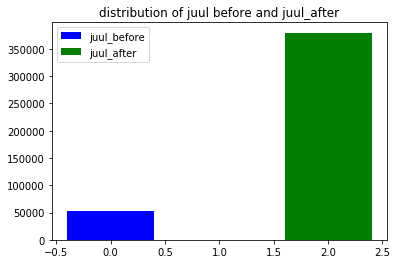

In [105]:
plt.title("distribution of juul before and juul_after")
plt.bar(np.arange(1),[len(juul_before)],color="blue",label="juul_before")
plt.bar(2,[len(juul_after)],color="green",label= "juul_after")
plt.legend()

In [ ]:
## lot of time to plot
plt.figure(figsize=(18,10))
users_list = list(first.userID.unique())
plt.scatter(list(first["juul_first"]),[str(user) for user in users_list],color="blue")
plt.scatter(list(first["weed_first"]), [str(user) for user in users_list],color="green")
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are of
plt.ylabel("users", fontsize = 15)
plt.xlabel("timeline ", fontsize=15)
plt.title("timeline of change of users from mono to poly" )

plt.show()

In [106]:
first["juul_first"] = pd.to_datetime(first["juul_first"])
first["weed_first"] = pd.to_datetime(first["weed_first"])
first_before = first.loc[first.userID.isin(juul_before)]
first_before["interval"] = first_before["weed_first"].dt.date - first["juul_first"].dt.date ## weed tweets wil be after juul


In [107]:
days = [ele.days for ele in list(first_before["interval"])]
days.sort()

In [108]:
pos = 0
counts = {}
delta = 30
counts[(pos+delta)] = 0
for ele in days:
    if  ele < pos + delta:
        counts[(pos+ delta)] += 1
    else:
        pos += delta
        counts[(pos + delta)] = 1

In [109]:
values = [ele[1] for ele in sorted(counts.items(), key=lambda x: x[0])]
keys = [ele[0] for ele in sorted(counts.items(), key=lambda x: x[0])]

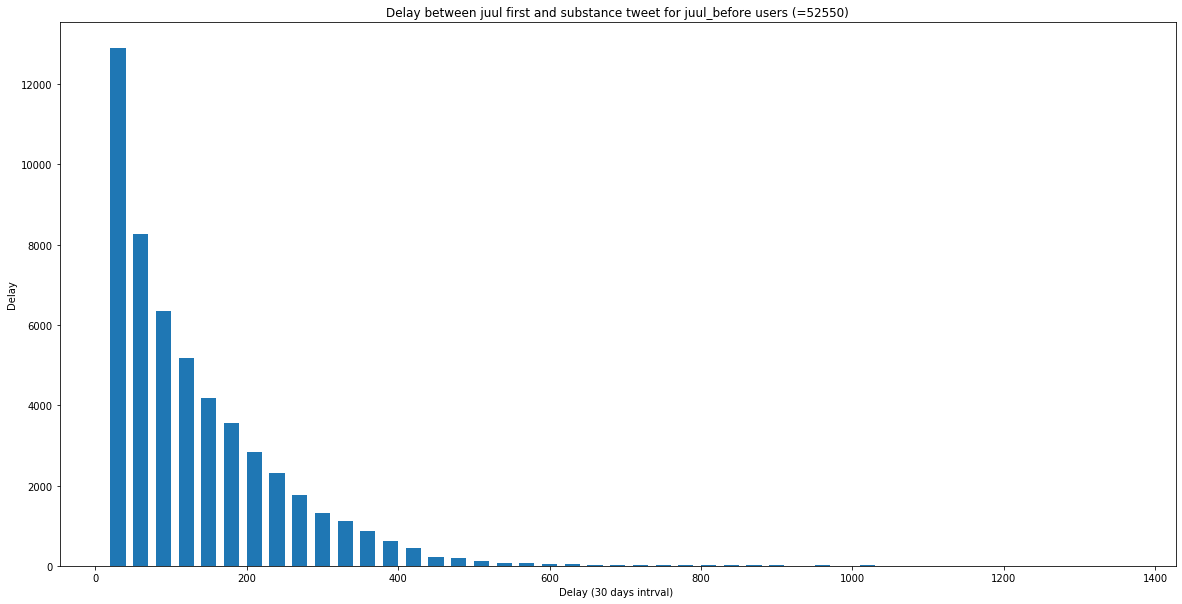

In [110]:
plt.figure(figsize=(20,10))
plt.bar(keys,values,width = 20)
plt.title("Delay between juul first and substance tweet for juul_before users (=52550)")
plt.xlabel("Delay (30 days intrval) ")
plt.ylabel("Delay")
plt.show()

## Training the classifier on poly and mono data

In [23]:
def get_length(text):
#     return(list(map(len, text.split())))
    return (len(text.split()))

In [24]:
def svm_wrapper(X_train,Y_train):
#     svm = SVC(kernel='rbf',C=10)
    svm = LinearSVC(C=1,verbose=1)
    svm.fit(X_train,Y_train,)
    return svm

In [300]:
len(mono_users)

42784

In [25]:
# weed data , poly data
weed_data = pd.read_csv(os.path.join(input_dir,"weed_data_text2.csv"),lineterminator="\n")
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")

In [26]:
juul_data = juul_data[["tweetCreatedAt","tweetId","tweetText", "userID"]]

In [27]:
## cleaning the text
tqdm.pandas()
weed_data["tweetText"] = weed_data["tweetText"].progress_apply(clean_text)
juul_data["tweetText"] = juul_data["tweetText"].progress_apply(clean_text)

In [28]:
poly_tweets_user = get_tweets_user(weed_data)
mono_tweets_user = get_tweets_user(juul_data)

In [29]:
poly_tweets_user['label'] = "poly"
mono_tweets_user['label'] = "mono"
frames = [poly_tweets_user, mono_tweets_user]
df_concat_tweets = pd.concat(frames)

In [30]:
length = ((df_concat_tweets["tweetText"])).progress_apply(get_length)

In [31]:
print("average legth of tweets",np.mean(length))
print("median legth of tweets",np.median(length))
max_len = int(np.median(length))

average legth of tweets 124.64053204067976
median legth of tweets 26.0


####  bilstm model

In [32]:
## taking only sample of the data (=1% of the data) as data is huge
df_tweets = (df_concat_tweets.sample(frac=0.01))

In [33]:
len(df_tweets)

14420

In [34]:
X,y, keras_tkzr = load_data(df_tweets,max_len)
vocab_size = len(keras_tkzr.word_index) + 1
vocab_size

fitting tokenizer on text
getting the encoded data
padding the input sequnce
labelling data


77163

In [35]:
X_train,X_test,Y_train,Y_test  = train_test_split(X, y,test_size =0.20,random_state= 4,shuffle=True ,)

In [36]:
print(X_train.shape)
print(X_test.shape)

(11536, 26)
(2884, 26)


In [37]:
#### embeddings
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")

In [38]:
word2vec = get_word2vec(embedding_file)
from numpy import zeros
embedding_matrix = zeros((vocab_size, 100))
for word, i in keras_tkzr.word_index.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [39]:
max_len= max_len
Dimension = 100
n_words = vocab_size
input = Input(shape=(max_len,))
model = Embedding(n_words,Dimension,weights=[embedding_matrix],input_length=max_len)(input)
model =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.25),merge_mode='concat')(model)
model = Flatten()(model)
model = Dense(100,activation='relu')(model)
output = Dense(1,activation='sigmoid')(model)

In [40]:
model = Model(input,output)

In [41]:
sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy']) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 26, 100)           7716300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 26, 200)           160800    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               520100    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 8,397,301
Trainable params: 8,397,301
Non-trainable params: 0
_________________________________________________________________


In [42]:
hist = model.fit(X_train,Y_train,validation_split=0.25, nb_epoch = 5, verbose = 1)

Train on 8652 samples, validate on 2884 samples
Epoch 1/5
8652/8652 [==============================] - 62s 7ms/step - loss: 0.2116 - acc: 0.9126 - val_loss: 0.0478 - val_acc: 0.9809
Epoch 2/5
8652/8652 [==============================] - 56s 6ms/step - loss: 0.0477 - acc: 0.9844 - val_loss: 0.0382 - val_acc: 0.9844
Epoch 3/5
8652/8652 [==============================] - 55s 6ms/step - loss: 0.0303 - acc: 0.9901 - val_loss: 0.0450 - val_acc: 0.9816
Epoch 4/5
8652/8652 [==============================] - 56s 6ms/step - loss: 0.0237 - acc: 0.9920 - val_loss: 0.0348 - val_acc: 0.9875
Epoch 5/5
8652/8652 [==============================] - 59s 7ms/step - loss: 0.0180 - acc: 0.9940 - val_loss: 0.0438 - val_acc: 0.9872


In [43]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 98.578363


In [44]:
from sklearn.metrics import classification_report,confusion_matrix
temp = model.predict(X_test)
y_pred = [0 if value< 0.5 else 1 for value in temp] 
print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')

  Classification Report:
              precision    recall  f1-score   support

          0       0.99      0.99      0.99      1808
          1       0.98      0.99      0.98      1076

avg / total       0.99      0.99      0.99      2884
 



In [45]:
svm = LinearSVC(C=1,verbose=1)
svm.fit(X_train,Y_train)
## svm accuracy on poly mono data ## C=1 kernel= linear
Y_pred = svm.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

[LibLinear]  Classification Report:
              precision    recall  f1-score   support

          0       0.63      0.42      0.51      1808
          1       0.38      0.59      0.46      1076

avg / total       0.54      0.48      0.49      2884
 



In [46]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
rf.fit(X_train,Y_train)
Y_pred = rf.predict(X_test)
print('  Classification Report Random forest (without PCA):\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

  Classification Report Random forest (without PCA):
              precision    recall  f1-score   support

          0       0.83      0.67      0.74      1808
          1       0.58      0.76      0.66      1076

avg / total       0.73      0.71      0.71      2884
 



0.7059639389736477

In [47]:
## etree without PCA
etree = ExtraTreesClassifier(n_estimators=200)
etree.fit(X_train,Y_train)
Y_pred = etree.predict(X_test)
print('  Classification Report Etree (without PCA):\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

  Classification Report Etree (without PCA):
              precision    recall  f1-score   support

          0       0.87      0.81      0.84      1808
          1       0.72      0.80      0.76      1076

avg / total       0.81      0.81      0.81      2884
 



0.8072122052704577

In [48]:
# from xgboost import XGBClassifier
# xgb = XGBClassifier()
# xgb.fit(X_train, y_train)
# Y_pred = etree.predict(X_test)
# print('  Classification Report Etree (without PCA):\n',classification_report(Y_test,Y_pred),'\n')
# ## accuarcy score
# (Y_test == Y_pred).mean()

In [54]:
## dump the models --  dump the lstm model
# dump_obj(model,os.path.join(classifier_dir,"lstm_model.pkl"))
dump_obj(keras_tkzr,os.path.join(classifier_dir,"keras_vect.pkl"))

#### PCA option

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_new = pca.fit_transform(X)
X_train,X_test,Y_train,Y_test  = train_test_split(X_new, y,test_size =0.20,random_state= 4 )

In [51]:
X_new.shape

(14420, 10)

In [ ]:
svm = SVC(C=1,kernel='linear',verbose=2)
svm.fit(X_train,Y_train)
## svm
Y_pred = svm.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

[LibSVM]

In [53]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
rf.fit(X_train,Y_train)
Y_pred = rf.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

  Classification Report:
              precision    recall  f1-score   support

          0       0.65      0.93      0.77      1808
          1       0.59      0.16      0.25      1076

avg / total       0.63      0.64      0.57      2884
 



0.644244105409154

## PREDICTING ESCALATION

### get the change of mono as(poly_before) to poly

In [ ]:
## bucket the users in bucket :
#1 2015 - [2015-2018] 
#2 2015- 2016 - [17 - 18]
#3 2015 - 2017 - [18]

In [ ]:
## we are taking final labels rather than next year

In [183]:
# so wil filter the users that does have weed tweet before 2016
# it return the mono user in that year
def get_mono(first_data,year):
    first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
    first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])
    juul_users = list(first_data["userID"].loc[first_data["juul_first"].dt.year < year])
    print("juul_initial",len(juul_users))
    weed_users = list(first_data["userID"].loc[(first_data["weed_first"].dt.year < (year))])
    mono_users = list(set(juul_users) - set(weed_users))
    print("mono final",len(mono_users))
    return mono_users

In [376]:
## return the label of the poly users
def get_label_mono(tweets_data,first_data):  ## will change for year
    users = tweets_data.userID.unique()
    print("initial_users",len(users))
    poly_labelled =  list(first_data["userID"].loc[first_data.userID.isin(users) & (first_data.weed_first.isnull())]) ## all not null will become poly
    mono_labelled = (list(set(users) - set(poly_labelled)))   ## users that will change to poly in future year
    print("poly_users that will change",len(poly_labelled))
    print("users reaminin mono",len(mono_labelled))
    tweets_data["label"] = 0   ## initialize
    tweets_data.loc[tweets_data.userID.isin(poly_labelled),"label"] = 1  # all of the poly
    return(tweets_data)

In [426]:
def get_f1(Y_true,Y_pred):
    f_scores = precision_recall_fscore_support(Y_true,Y_pred)[2]
    supports = precision_recall_fscore_support(Y_true,Y_pred)[3]
    f1_num = 0
    for f_s,sup in zip(f_scores,supports):
        f1_num += (f_s * sup)
    f1 = f1_num / np.sum(supports)
    return(f1)

In [173]:
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
regular_users = pickle.load(open(os.path.join(poly_dir,"regular_users.pkl"),"rb"))
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
mono_users = pickle.load(open(os.path.join(poly_dir,"mono_users.pkl"),"rb"))

In [161]:
# weed data , poly data
weed_data = pd.read_csv(os.path.join(input_dir,"weed_data_text2.csv"),lineterminator="\n")
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")

In [171]:
(first_data.loc[(first_data.weed_first.isnull()) & (first_data.juul_first.dt.year < 2018)])

,userID,juul_first,weed_first
60,22823,2016-11-12 02:59:03,NaT
75,54913,2017-07-07 21:21:45,NaT
76,59453,2015-06-11 06:41:00,NaT
89,82063,2015-09-18 11:50:36,NaT
154,733293,2016-05-03 07:42:06,NaT
176,767578,2017-11-09 22:41:51,NaT
271,1154181,2015-06-03 18:03:55,NaT
323,1503691,2015-12-14 14:20:16,NaT
326,1533411,2017-06-22 03:18:39,NaT
350,1753061,2017-03-10 12:11:52,NaT


In [ ]:
## we taking 15 data from juul and weed and not use the pattern
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
## filter the juul data to capture just the regualr users
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

## we keep only the regular usrs
first_data = first_data.loc[first_data.userID.isin(regular_users)]

In [310]:
len(first_data)  ## equal to the regular users

673724

In [176]:
## so we will label the users based on the first weed tweet of the user and if the first weed tweet does not exist
# then that user is considered mono

In [311]:
## load the model and tokenizer
lstm_model = pickle.load(open(os.path.join(classifier_dir,"lstm_model.pkl"),"rb"))
keras_tkzr = pickle.load(open(os.path.join(classifier_dir,"lstm_vect.pkl"),"rb"))

## bucket 1

In [428]:
mono_ = get_mono(first_data,2016)

juul_initial 1792
mono final 1140


In [429]:
len(set(mono_users).intersection(set(mono_))) ## this should be labelled as 0
# first_data.loc[first_data.userID.isin(mono_)]

952

In [430]:
 ## select the data for the users in that year
mono_data_2015 = juul_data.loc[(juul_data.userID.isin(mono_)) & (juul_data.tweetCreatedAt.dt.year < 2016)]  
print(len(mono_data_2015))
print(len(mono_data_2015.userID.unique()))
tweets_2015 = get_tweets_user(mono_data_2015)  ## concatenating tweets by user

2131
1140


In [431]:
print("tweets",len(tweets_2015))
print("users",len(tweets_2015.userID.unique()))

tweets 1140
users 1140


In [432]:
tweets_2015 = get_label_mono(tweets_2015,first_data)

initial_users 1140
poly_users that will change 952
users reaminin mono 188


In [433]:
tweets_2015["label"].unique()
## 0 : mono
## 1 : poly
Y_true = list(tweets_2015["label"])
print("mono",len([ele for ele in Y_true if ele == 0]))
print("poly",len([ele for ele in Y_true if ele == 1]))

mono 188
poly 952


In [434]:
## clean the tweets
tweets_2015["tweetText"] = tweets_2015["tweetText"].apply(clean_text)

In [435]:
max_len = 26
encoded_docs = keras_tkzr.texts_to_sequences(tweets_2015["tweetText"])
X_new = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
print(X_new.shape)

(1140, 26)


In [436]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 26, 100)           7716300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 26, 200)           160800    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               520100    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 8,397,301
Trainable params: 8,397,301
Non-trainable params: 0
_________________________________________________________________


In [437]:
Y_pred = [np.argmax(ele) for ele in lstm_model.predict(X_new,verbose=1)]

1140/1140 [==============================] - 1s 586us/step


In [438]:
lstm = []
print('  Classification Report:\n',classification_report(Y_true,Y_pred),'\n')
lstm.append(get_f1(Y_true,Y_pred))

  Classification Report:
              precision    recall  f1-score   support

          0       0.16      1.00      0.28       188
          1       0.00      0.00      0.00       952

avg / total       0.03      0.16      0.05      1140
 



In [439]:
## majority classifier
majority = []
Y_pred = [1  for ele in range(len(Y_true))]
print('  Classification Report:\n',classification_report(Y_true,Y_pred),'\n')
majority.append(get_f1(Y_true,Y_pred))

  Classification Report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00       188
          1       0.84      1.00      0.91       952

avg / total       0.70      0.84      0.76      1140
 



## bucket 2

In [440]:
year = 2017
mono_ = get_mono(first_data,year)

juul_initial 5619
mono final 2861


In [441]:
len(set(mono_users).intersection(set(mono_))) ## this should be labelled as 0
# first_data.loc[first_data.userID.isin(mono_)]

2329

In [442]:
 ## select the data for the users in that year
mono_data_ = juul_data.loc[(juul_data.userID.isin(mono_)) & (juul_data.tweetCreatedAt.dt.year < year)]  
print("length of data in that span",len(mono_data_))
print("users:",len(mono_data_.userID.unique()))
tweets_ = get_tweets_user(mono_data_)  ## concatenating tweets by user

length of data in that span 6806
users: 2861


In [443]:
print("tweets",len(tweets_))
print("users",len(tweets_.userID.unique()))

tweets 2861
users 2861


In [444]:
tweets_ = get_label_mono(tweets_,first_data)

initial_users 2861
poly_users that will change 2329
users reaminin mono 532


In [445]:
tweets_["label"].unique()
## 0 : mono
## 1 : poly
Y_true = list(tweets_["label"])
print("mono",len([ele for ele in Y_true if ele == 0]))
print("poly",len([ele for ele in Y_true if ele == 1]))

mono 532
poly 2329


In [446]:
## clean the tweets
tweets_["tweetText"] = tweets_["tweetText"].apply(clean_text)

In [447]:
max_len = 26
encoded_docs = keras_tkzr.texts_to_sequences(tweets_["tweetText"])
X_new = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
print(X_new.shape)

(2861, 26)


In [448]:
Y_pred = [np.argmax(ele) for ele in lstm_model.predict(X_new,verbose=1)]

2861/2861 [==============================] - 2s 681us/step


In [449]:
print('  Classification Report:\n',classification_report(Y_true,Y_pred),'\n')
lstm.append(get_f1(Y_true,Y_pred))

  Classification Report:
              precision    recall  f1-score   support

          0       0.19      1.00      0.31       532
          1       0.00      0.00      0.00      2329

avg / total       0.03      0.19      0.06      2861
 



In [450]:
## majority classifier
Y_pred = [1  for ele in range(len(Y_true))]
print('  Classification Report:\n',classification_report(Y_true,Y_pred),'\n')
majority.append(get_f1(Y_true,Y_pred))

  Classification Report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00       532
          1       0.81      1.00      0.90      2329

avg / total       0.66      0.81      0.73      2861
 



## bucket 3 - (2015-2017 ;  2018)

In [451]:
year = 2018
mono_ = get_mono(first_data,year)

juul_initial 113426
mono final 42784


In [452]:
len(set(mono_users).intersection(set(mono_))) ## this should be labelled as 0
# first_data.loc[first_data.userID.isin(mono_)]

33259

In [453]:
 ## select the data for the users in that year
mono_data_ = juul_data.loc[(juul_data.userID.isin(mono_)) & (juul_data.tweetCreatedAt.dt.year < year)]  
print("length of data in that span",len(mono_data_))
print("users:",len(mono_data_.userID.unique()))
tweets_ = get_tweets_user(mono_data_)  ## concatenating tweets by user

length of data in that span 62655
users: 42784


In [454]:
print("tweets",len(tweets_))
print("users",len(tweets_.userID.unique()))

tweets 42784
users 42784


In [455]:
tweets_ = get_label_mono(tweets_,first_data)

initial_users 42784
poly_users that will change 33259
users reaminin mono 9525


In [456]:
tweets_["label"].unique()
## 0 : mono
## 1 : poly
Y_true = list(tweets_["label"])
print("mono",len([ele for ele in Y_true if ele == 0]))
print("poly",len([ele for ele in Y_true if ele == 1]))

mono 9525
poly 33259


In [457]:
## clean the tweets
tweets_["tweetText"] = tweets_["tweetText"].apply(clean_text)

In [458]:
max_len = 26
encoded_docs = keras_tkzr.texts_to_sequences(tweets_["tweetText"])
X_new = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
print(X_new.shape)

(42784, 26)


In [459]:
Y_pred = [np.argmax(ele) for ele in lstm_model.predict(X_new,verbose=1)]

42784/42784 [==============================] - 28s 664us/step


In [460]:
print('  Classification Report:\n',classification_report(Y_true,Y_pred),'\n')
lstm.append(get_f1(Y_true,Y_pred))

  Classification Report:
              precision    recall  f1-score   support

          0       0.22      1.00      0.36      9525
          1       0.00      0.00      0.00     33259

avg / total       0.05      0.22      0.08     42784
 



In [461]:
## majority classifier
Y_pred = [1  for ele in range(len(Y_true))]
print('  Classification Report:\n',classification_report(Y_true,Y_pred),'\n')
majority.append(get_f1(Y_true,Y_pred))

  Classification Report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00      9525
          1       0.78      1.00      0.87     33259

avg / total       0.60      0.78      0.68     42784
 



### plotting the classfier acuuracy 

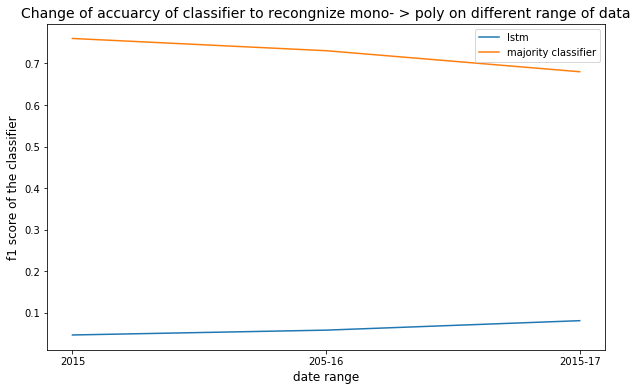

In [466]:
fig, ax = plt.subplots(figsize = (10,6))
x_label = ["2015","205-16","2015-17"]
ax.plot(x_label,lstm,label="lstm")
ax.plot(x_label,majority,label="majority classifier")
plt.title("Change of accuarcy of classifier to recongnize mono- > poly on different range of data",fontsize=14)
plt.xlabel("date range",fontsize=12)
plt.ylabel("f1 score of the classifier",fontsize=12)
plt.legend()
# for i, v in enumerate(lstm):
#     plt.text(i - 0.09,v + 0.01, str(v), color='blue', fontweight='bold')
#-- need to change with f1 score acuarcy instead of just poly_accuarcy

# looking at the most predictive weights for the SVM classifier

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer as keras_Tokenizer
from sklearn.metrics import classification_report
keras_tkzr = keras_Tokenizer()

In [ ]:
def clean_tweets(df):
    df["tweetText"] = df["tweetText"].apply(clean_text)
    df["tweetText"] = df["tweetText"].apply(prepare_text_LDA)
    return (df)

In [ ]:
def get_label(df):
    # poly_users global
    label = []
    for idx,row in df.iterrows():
        if row['userID'] in poly_users:
            label.append("poly")
        else:
            label.append("mono")
    return label

In [ ]:
def encode(label):
    le = LabelEncoder()
    le.fit(label)
    y = le.transform(label)
    return y

In [ ]:
def get_data(df):
    label = get_label(df)
#     y = encode(label)
    tf_idf = TfidfVectorizer(sublinear_tf=True)
    tf_idf.fit(df["tweetText"])
    feature_names = np.array(tf_idf.get_feature_names())
    X = tf_idf.fit_transform(df["tweetText"])
    print(X.shape)
    return (X,np.array(label),tf_idf)

In [ ]:
def plot_coeff(k,model,feature_names):
    coef = (model.coef_.ravel()) 
    top_positive_coefficients = np.argsort(coef)[-k:]
    top_negative_coefficients = np.argsort(coef)[:k]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(20, 8))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * k), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * k), feature_names[top_coefficients], rotation=60, ha='right',fontsize= 20)
    plt.show()
    return coef

In [ ]:
len(df_tweets.userID.unique())

In [ ]:
tweets_all = df_tweets.loc[df_tweets.userID.isin(normal_users)]

In [ ]:
print("total tweets ",len(tweets_all))
print("users", len(tweets_all.userID.unique()))

In [ ]:
tweets_ = clean_tweets(tweets_all)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X,y,tf_idf_final = get_data(tweets_user)
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)
svm_final = svm_wrapper(X_train,Y_train)
## svm accuracy on poly mono data ## C=1 kernel= linear
Y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

In [ ]:
np.mean(Y_test == Y_pred)

In [ ]:
## shape
print(X_train.shape)
print(Y_train.shape)

In [ ]:
## vocalb size
print(len(tf_idf.get_feature_names()))

In [ ]:
coeff = plot_coeff(20,svm_final,tf_idf_final.get_feature_names())

In [ ]:
k = 20
coef = (svm.coef_.ravel()) 
feature_names = np.array(tf_idf.get_feature_names())
top_positive_coefficients = np.argsort(coef)[-k:]
list(feature_names[top_positive_coefficients][::-1])

In [ ]:
top_negative_coefficients = np.argsort(coef)[:k]
list(feature_names[top_negative_coefficients])

# Buckets - svm

## bucket 2014

In [ ]:
tweets_all = df_tweets.loc[df_tweets.userID.isin(normal_users)]
f_scores = []
years = []

In [ ]:
tweets_all["tweetCreatedAt"] = pd.to_datetime(tweets_all.tweetCreatedAt)

In [ ]:
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2015]

In [ ]:
print("tweets",len(tweets))
print("users",len(tweets.userID.unique()))

In [ ]:
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X,y,tf_idf = get_data(tweets_user)
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)
svm = svm_wrapper(X_train,Y_train)
## svm accuracy on poly mono data ## C=1 kernel= linear
Y_pred = svm.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
_,_,fscore,_ = precision_recall_fscore_support(Y_test,Y_pred)
# print(np.average(fscore))
f_scores.append(np.average(fscore)) 

In [ ]:
coeff = plot_coeff(20,svm,tf_idf.get_feature_names())

In [ ]:
plt.figure(figsize=(10,5))
years = ["2014-2015"]
plt.scatter(years, f_scores)
plt.title("Training accuarcy of classifier(SVM) on tweets for different time range",fontsize = 20)
plt.xlabel("Range of year span ",fontsize = 16)
plt.ylabel("f1-score",fontsize = 16)
plt.xticks(rotation=30, ha='center')
plt.show()

## bucket 2015

In [ ]:
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2016]

In [ ]:
print("tweets",len(tweets))
print("users",len(tweets.userID.unique()))

In [ ]:
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X,y,tf_idf = get_data(tweets_user)
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)
svm = svm_wrapper(X_train,Y_train)
## svm accuracy on poly mono data ## C=1 kernel= linear
Y_pred = svm.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
_,_,fscore,_ = precision_recall_fscore_support(Y_test,Y_pred)
# print(np.average(fscore))
f_scores.append(np.average(fscore)) 

In [ ]:
coeff = plot_coeff(20,svm,tf_idf.get_feature_names())

In [ ]:
plt.figure(figsize=(10,5))
years = ["2014-15","2014-16"]
plt.scatter(years, f_scores)
plt.title("Training accuarcy of classifier(SVM) on tweets for different time range",fontsize = 20)
plt.xlabel("Range of year span ",fontsize = 16)
plt.ylabel("f1-score",fontsize = 16)
plt.xticks(rotation=30, ha='center')
plt.show()

# Bucket 2016

In [ ]:
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2017]

In [ ]:
print("tweets",len(tweets))
print("users",len(tweets.userID.unique()))

In [ ]:
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X,y,tf_idf = get_data(tweets_user)
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)
svm = svm_wrapper(X_train,Y_train)
## svm accuracy on poly mono data ## C=1 kernel= linear
Y_pred = svm.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
_,_,fscore,_ = precision_recall_fscore_support(Y_test,Y_pred)
# print(np.average(fscore))
f_scores.append(np.average(fscore)) 

In [ ]:
coeff = plot_coeff(20,svm,tf_idf.get_feature_names())

In [ ]:
plt.figure(figsize=(10,5))
years = ["2014-15","2014-16","2014-17"]
plt.scatter(years, f_scores)
plt.title("Training accuarcy of classifier(SVM) on tweets for different time range",fontsize = 20)
plt.xlabel("Range of year span ",fontsize = 16)
plt.ylabel("f1-score",fontsize = 16)
plt.xticks(rotation=30, ha='center')
plt.show()

##  bucket 2017

In [ ]:
year_c = 2018
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < year_c]
print("tweets",len(tweets))
print("users",len(tweets.userID.unique()))
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X,y,tf_idf = get_data(tweets_user)
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)
svm = svm_wrapper(X_train,Y_train)
## svm accuracy on poly mono data ## C=1 kernel= linear
Y_pred = svm.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
_,_,fscore,_ = precision_recall_fscore_support(Y_test,Y_pred)
# print(np.average(fscore))
f_scores.append(np.average(fscore)) 

In [ ]:
coeff = plot_coeff(20,svm,tf_idf.get_feature_names())

In [ ]:
plt.figure(figsize=(10,5))
years = ["2014-15","2014-16","2014-17","2014-18"]
plt.plot(years, f_scores)
plt.title("Training accuarcy of classifier(SVM) on tweets for different time range",fontsize = 20)
plt.xlabel("Range of year span ",fontsize = 16)
plt.ylabel("f1-score",fontsize = 16)
plt.xticks(rotation=30, ha='center')
plt.show()

# change of accuracy of the svm model using only the specific year data

In [ ]:
## prediction
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2015]
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X_test = tf_idf_final.transform(tweets_user["tweetText"])
Y_true = get_label(tweets_user)
y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_true,y_pred),'\n')

In [ ]:
year_c = 2016
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < year_c]
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X_test = tf_idf_final.transform(tweets_user["tweetText"])
Y_true = get_label(tweets_user)
y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_true,y_pred),'\n')

In [ ]:
year_c = 2017
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < year_c]
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X_test = tf_idf_final.transform(tweets_user["tweetText"])
Y_true = get_label(tweets_user)
y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_true,y_pred),'\n')

In [ ]:
year_c = 2018
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < year_c]
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X_test = tf_idf_final.transform(tweets_user["tweetText"])
Y_true = get_label(tweets_user)
y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_true,y_pred),'\n')

In [ ]:
year_c = 2019
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < year_c]
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X_test = tf_idf_final.transform(tweets_user["tweetText"])
Y_true = get_label(tweets_user)
y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_true,y_pred),'\n')

## looking at the cascades

In [ ]:
import operator
def get_depth(G):
    level = nx.get_node_attributes(G,'level')
    if not level:
        level = nx.get_node_attributes(G,'depth')
    depth = max(level.items(), key=operator.itemgetter(1))[1]
    return depth

In [ ]:
graph_path = os.path.join(top_dir,"models","graphs2")

In [ ]:
filenames = [file for file in os.listdir(os.path.join(os.getcwd(),graph_path)) if file.endswith(".gpickle")]

In [ ]:
len(filenames)

In [ ]:
def get_type_nodes(G,main_node,poly_users):
    poly_nodes = []
    mono_nodes = []
    for node in G:
        if node != main_node:
            if node in set(poly_users):
                poly_nodes.append(node)
            else:
                mono_nodes.append(node)
    return (poly_nodes,mono_nodes)

## gettng the network properties

In [ ]:
df_following_final = pd.read_csv(os.path.join(input_dir,"following_final.csv"))

In [ ]:
print(len(normal_users))
print(len(poly_users))
print(len(mono_users))

In [ ]:
## selecting a subset of the following that contain the total users
df_poly_users = df_following_final[df_following_final.userID.isin(poly_users)]
df_mono_users = df_following_final[df_following_final.userID.isin(mono_users)]
df_all_users = df_following_final[df_following_final.userID.isin(total_users)]

In [ ]:
def get_graph(df):
    G = nx.DiGraph()
    users = list(df.userID.unique())
    for user in tqdm(users):
        following_A = set(ast.literal_eval((df.loc[df.userID == user].head(1)["following"].values)[0]))
        user_set = set([node for node in users if node != user])
        users_list = user_set.intersection(following_A)
        for user_following in list(users_list):
            G.add_edge(user,user_following)
    return G

In [ ]:
G_poly = get_graph(df_poly_users)
G_mono = get_graph(df_mono_users)
G_all = get_graph(df_all_users)

In [ ]:
# color map 
def get_color_map(G,poly_users):
    color_map = list()
    for node in G.nodes():
        if int(node) in set(poly_users):
            color_map.append('green')
        else:
            color_map.append('blue')
    return color_map

In [ ]:
## mono viz --(filetersd)
color_map = get_color_map(G_mono,poly_users)
plt.figure(figsize=(30,30))
nx.draw(G_mono,node_color=color_map)

In [ ]:
color_map = get_color_map(G_poly,poly_users)
plt.figure(figsize=(30,30))
nx.draw(G_poly,node_color=color_map)

In [ ]:
plt.figure(figsize=(50,50))
color_map = get_color_map(G_all,poly_users)
pos = nx.spring_layout(G_all)
nx.draw_networkx(G_all, pos=pos, node_color = color_map,with_label = False,arrows=True,labels=None)
plt.show()

In [ ]:
print(nx.info(G_all))
print("average clustering poly",nx.average_clustering(G_all))

In [ ]:
print(nx.info(G_mono))
print("average clustering poly",nx.average_clustering(G_mono))

In [ ]:
print(nx.info(G_poly))
print("average clustering mono",nx.average_clustering(G_poly))

In [ ]:
## checking the influence in the cascades..
## influence = no of poly/mono / total no of nodes
influence_poly = []
influence_mono = []
for file in filenames:
    G = nx.read_gpickle(os.path.join(graph_path,file))
    depth = nx.get_node_attributes(G,'level')
    main_node = [node for node,level in depth.items() if level ==0]
    poly_nodes,mono_nodes =  get_type_nodes(G,main_node,poly_users)
#     if len(G.nodes) > 30:
    if main_node[0] in set(poly_users):
        influence_poly.append(len(poly_nodes)/(len(poly_nodes)+len(mono_nodes)))
    else:
        influence_mono.append(len(mono_nodes)/(len(poly_nodes)+len(mono_nodes)))

In [ ]:
len(influence_poly)

In [ ]:
len(influence_mono)

In [ ]:
np.mean(influence_mono) 

In [ ]:
np.mean(influence_poly)

In [ ]:
len(poly_users)